### Statement of the problem:

CoverMyMeds Challenge Problem
At CoverMyMeds, time series analysis forms the backbone of the financial projections we make at the beginning of each fiscal year and helps us set realistic but challenging company goals.  Many of our products have multiple customers whose behaviors might (or might not) influence each other.  We are presenting daily volume (can be thought of as purchases) of one product for three customers. Questions that you should answer in this project are the following: 
* What trends are in the data at the daily, monthly, and yearly levels?
* What variables do and do not affect daily volume?
* How does the behavior of one customer affect the behavior of the other customers?
* How accurately can you predict what will happen in 2019 at the monthly and yearly levels?
* How accurate are your projections 1 month, 3 months, and 6 months after the  day they were forecasted from?

### Exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
np.random.seed(1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df.shape

Very small data size

In [ ]:
df.head()

Check if there's missing value

In [ ]:
df.isna().sum()

In [ ]:
df[['volume_A','volume_B', 'volume_C']].describe()

Convert 1sf column to datetime type

In [ ]:
df['date_val'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date_val'], inplace = True)

In [ ]:
dayly_effect = df.groupby('day_of_week')[['volume_A', 'volume_B', 'volume_C']].sum()

In [ ]:
plt.plot(dayly_effect)
plt.show()

In [ ]:
weekday_effect

In [ ]:
weekday_effect = df.groupby('is_weekday')[['volume_A', 'volume_B', 'volume_C']].sum()
weekday_effect

In [ ]:
df.groupby('is_holiday')[['volume_A', 'volume_B', 'volume_C']].sum()

In [ ]:
df[['volume_A','volume_B', 'volume_C']].describe()

In [ ]:
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])

Inspect correlation

In [ ]:
df_new.corr()

In [ ]:
# scatter matrix makes a matrix of scatter plots
from pandas.plotting import scatter_matrix

scatter_matrix(df_new, figsize = (14,14), alpha = 1)

plt.show()

In [ ]:
df_new['volume_C'].plot(figsize=(10, 5))
plt.show()

In [ ]:
test_a = df_new['volume_A'].to_numpy()

### Exponential smoothing, ARIMA

In [2]:
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date'], inplace = True)
df_new = df.drop(columns = ['date_val','calendar_year', 'calendar_month', 'calendar_day', 'day_of_week'])
df_new = df_new.rename(columns={'volume_A': 'vol_A', 'volume_B': 'vol_B', 'volume_C': 'vol_C'})
df_new = df_new.asfreq(freq='D')

In [42]:
from models.models import Data_Pipe, ARIMA_model

para_model = {'window': 60, 'scale': False, 'smooth': False, 'scale_type': 'max_min', 
              'target': 'vol_C', 'external': 'is_weekday', 
              'dtype': None, 'p': 2, 'q': 0, 'd': 0}
model = ARIMA_model(df_new, **para_model)

In [43]:
model.build_model()
model.fit_model()

In [8]:
model.stationary_test()

the time series vol_C is non-stationary!


/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/emp/anaconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [44]:
model.get_prediction()

In [39]:
x = pd.DataFrame(np.array([model.upper_bound.to_numpy(),model.lower_bound.to_numpy()]).T, columns=['upper_bound', 'lower_bound'], index=model.test.index)

In [47]:
model.combine_data

,fit_data,real_data,error_rate,lower_bound,upper_bound,std_err
2017-01-01,1330.116101,574,131.727544,NaN,NaN,NaN
2017-01-02,3305.286738,3149,4.963059,NaN,NaN,NaN
2017-01-03,3330.483721,3595,7.357894,NaN,NaN,NaN
2017-01-04,3526.813238,3651,3.401445,NaN,NaN,NaN
2017-01-05,3617.797844,3792,4.593939,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-12-27,3603.482431,3661,1.571089,2720.081590,4486.883271,450.722997
2019-12-28,1330.116101,1232,7.963969,446.715261,2213.516941,450.722997
2019-12-29,1330.116101,1349,1.399844,446.715261,2213.516941,450.722997
2019-12-30,3603.482431,3690,2.344650,2720.081590,4486.883271,450.722997


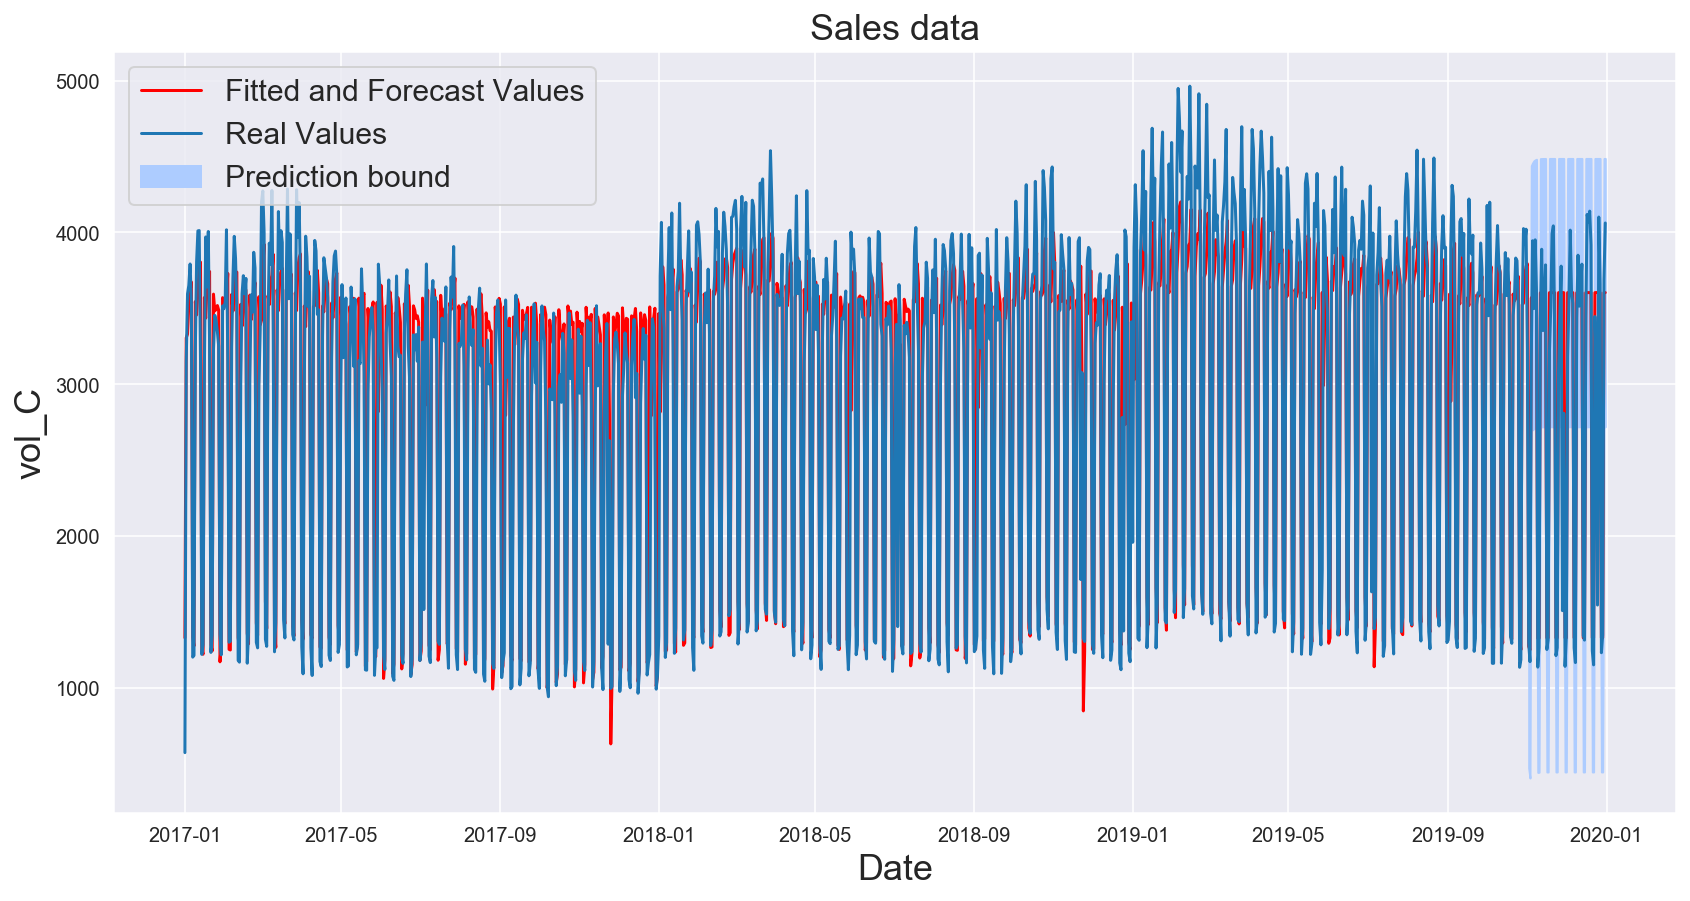

In [60]:
model.plot_data()

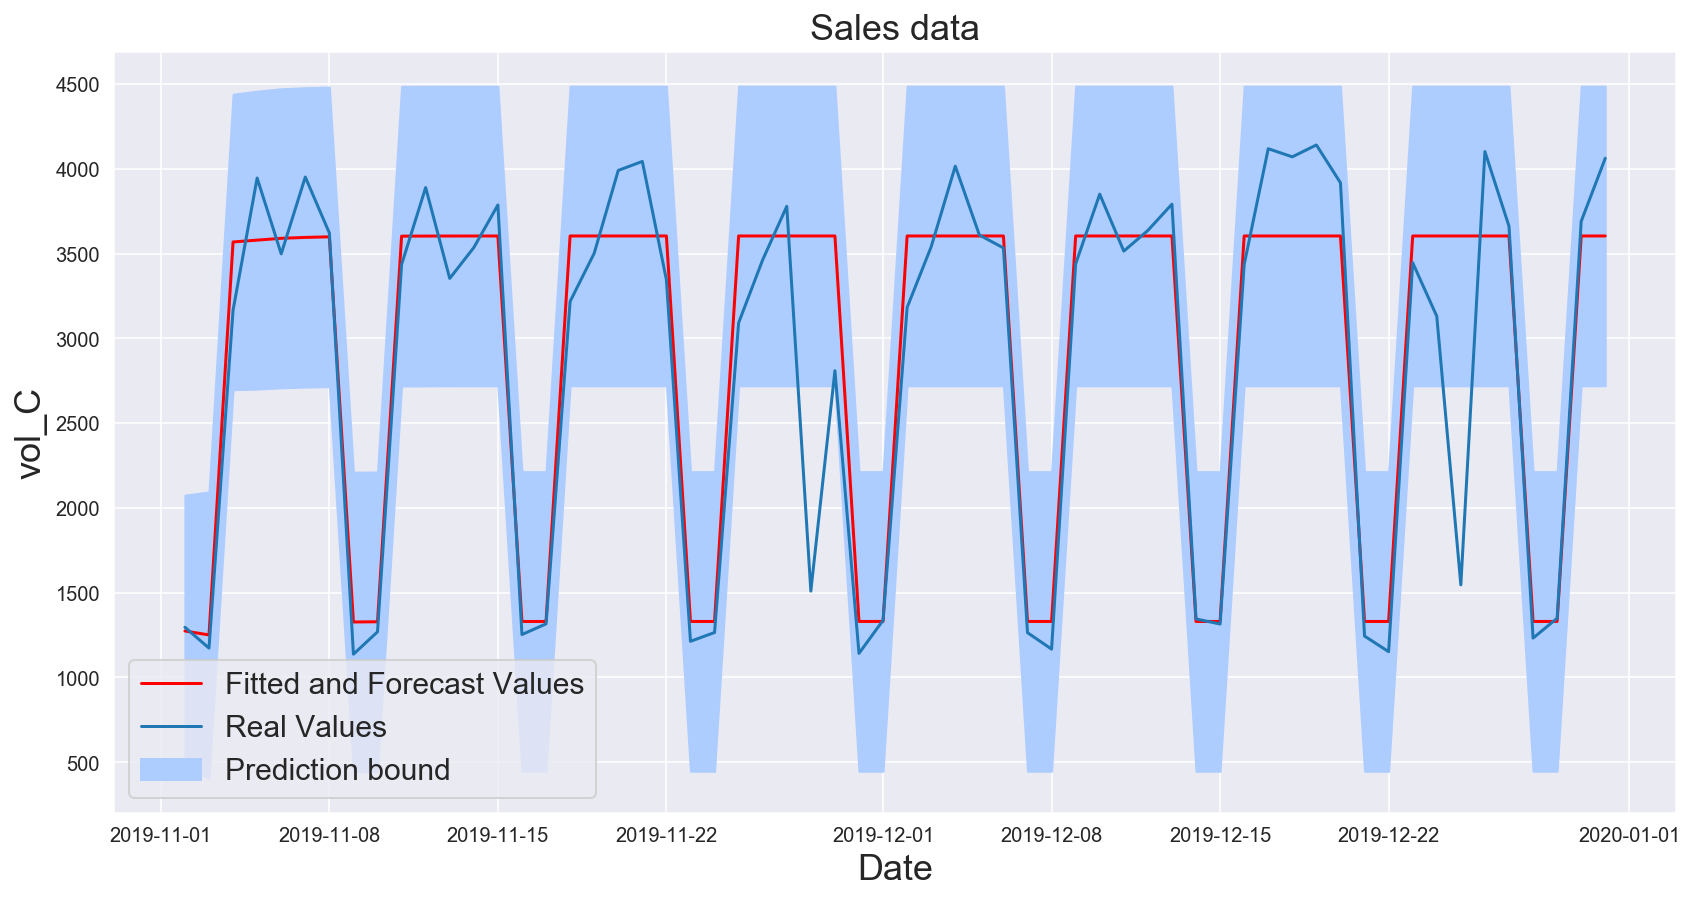

In [61]:
model.plot_data(plot_all = False)

In [ ]:
model.error_rate[-len(model.test):].mean()

### Backtest for model selection

In [ ]:
from models.backtest import Backtest_ARIMA

# copy parameters for building the ARIMA model
para_back_test = para_model
month = 30
extra_para = {'p_max': 2, 'q_max': 2, 'd_max': 1, 'method': 'expand', 'span': 12*month, 'slide': 2*month}
# update parameters for backtesting
para_back_test.update(extra_para)

In [ ]:
backtest = Backtest_ARIMA(df_new, **para_back_test)

In [ ]:
backtest.model_selection()

In [ ]:
backtest.mse_scores

In [ ]:
backtest.aic_scores

### Modeling as Structure Time Series (STS) using tensorflow probability 

In [ ]:
from models.plot import plot_forecast
from models.models import STS_model
import matplotlib.dates as mdates

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts
import matplotlib.dates as mdates

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date'], inplace = True)
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])
train_A, test_A = df_new['volume_A'].loc[:'2018-12-31'], df_new['volume_A'].loc['2019-1-1':]
train_A, test_A = train_A.to_numpy(dtype='float32'), test_A.to_numpy(dtype='float32')

In [ ]:
model_A = STS_model(train_A)
model_A.build_model()

In [ ]:
surrogate_posterior = tfp.sts.build_factored_surrogate_posterior(model = model_A.model)

In [ ]:
model_A.num

In [ ]:
num_variational_steps = 100

@tf.function(experimental_compile=True)
def train(model):
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn = model_A.model.joint_log_prob(
        observed_time_series = model_A.obs),
    surrogate_posterior = surrogate_posterior,
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    num_steps = num_variational_steps)
    
    return elbo_loss_curve

In [ ]:
train(model_A.model)

### Modeling using LSTM (PyTorch)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# needs to install pyarrow
df = pd.read_parquet('data/cmm_erdos_bootcamp_2020_timeseries.pq', engine='auto')
df['date_val'] = pd.to_datetime(df['date_val'], yearfirst=True)
df.set_index(['date_val'], inplace = True)
df_new = df.drop(columns = ['calendar_year', 'calendar_month', 'calendar_day'])
train_A, test_A = df_new['volume_A'].loc[:'2018-12-31'], df_new['volume_A'].loc['2019-1-1':]
train_A, test_A = train_A.to_numpy(dtype='float32'), test_A.to_numpy(dtype='float32')

Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is important. The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input.

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])
plt.show()

In [ ]:
all_data = flight_data['passengers'].values.astype(float)
test_size = 12
train_data = all_data[:-test_size]
test_data = all_data[-test_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [ ]:
train_window = 12
# sliding window approach
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_normalized, train_window)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

In [ ]:
train_inout_seq[0][0]

In [ ]:
train_inout_seq[0][1]

In [ ]:
model(train_inout_seq[0][0])

In [ ]:
epochs = 150
fit = []
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        fit.append(y_pred)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
pred_span = 12

test_inputs = train_normalized[-train_window:].tolist()
print(test_inputs)

In [ ]:
model.eval()
pred = []
for i in range(pred_span):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    #seq = torch.FloatTensor(train_normalized[-train_window:].ravel())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred.append(model(seq).item())

In [ ]:
train_normalized

In [ ]:
model.eval()
fit = []
for i in range(len(train_normalized)):
    seq = train_normalized
    #seq = torch.FloatTensor(train_normalized[-train_window:].ravel())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        fit.append(model(seq).item())

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
actual_fit = scaler.inverse_transform(np.array(fit).reshape(-1, 1))

In [ ]:
actual_fit

In [ ]:
x = np.arange(132, 144)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data.index, flight_data['passengers'])
plt.plot(x, actual_fit)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()